In [1]:
import sys
import math
import pandas as pd
import numpy as np
import causalimpact as ci
import json
import matplotlib.pyplot as plt
import warnings

sys.path.append('c:\\Users\\Jordi Cremades\\Documents\\Repository')

from Utilities import reader_writer
from Utilities import query_engines

rw = reader_writer.Reader_Writer()

# SPM Impact Analysis

**Context**
<br>
We run different tests to test the aggressivity impact of the thresholds. 
<br>
<br>
This notebook is the analysis resolution of a synthetic analysis.
<br>
<br>

**Approach before test**
- 80% TREAT, 20% CONTROL
- We use 7 complete weeks of data. 5 weeks to predict 2.
<br>
<br>

**Approach after test**
- We use the following 2 weeks to evaluate impact

### Collect and classify data

In [6]:
# We load the stores that where present in the test
d_stores = rw.csv_read_file('CARR_IT_24_04_2023.csv')
d_stores

,store_address,Group
0,103368,Treat
1,104278,Treat
2,104282,Treat
3,10559,Treat
4,113368,Treat
...,...,...
300,8574,Treat
301,8924,Treat
302,9049,Treat
303,9050,Treat


In [7]:
# Enrich d_stores with Orders and PNA Orders information

# Parameters
start_date = '2023-03-06'
end_date = '2023-05-07'
store_addresses = ",".join(str(val) for val in d_stores['store_address'].unique().tolist())

# Params
params = [
    {'name':'store_addresses', 'value':store_addresses}
    ,{'name':'start_date', 'value':start_date}
    ,{'name':'end_date', 'value':end_date}
]

# Query
query = query_engines.QueryEngines(
    query='SPM/SPM_group_creator.sql', 
    del1='--v1', 
    del2='--end_v1',
    params=params,
    output_dir=None,
    output_file=None,
    printq=None
)

d_pna = query.query_run_starbust()

c:\Users\Jordi Cremades\Documents\Repository\Utilities\query_engines.py:151: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


In [10]:
# Merge the information with the interested store_addresses
d_filtered = pd.merge(d_stores
    ,d_pna
    ,left_on=['store_address']
    ,right_on=['order_descriptors.store_address_id']
    ,how='inner')

# Delete unnecessary columns
d_filtered.drop(columns=['order_descriptors.store_address_id'
    ,'order_descriptors.store_name'], inplace=True)

# Rename columns
d_filtered = d_filtered.rename(columns={'store_address': 'store_address'
    ,'order_timelines.order_activated_local_at': 'date'
    ,'bought_products.number_of_distinct_orders': 'orders'
    ,'bought_products_additions_removals_replacements.number_of_orders_with_pna_1': 'orders_pna'})

print('There are {} distinct dates'.format(d_filtered['date'].nunique()))
print("Min Date = {}".format(d_filtered['date'].min()))
print("Max Date = {}".format(d_filtered['date'].max()))
print('There are {} store addresses'.format(d_filtered['store_address'].nunique()))
print('There are {} Control store addresses'.format(d_filtered[d_filtered['Group']=='Control']['store_address'].nunique()))
print('There are {} Treat store addresses'.format(d_filtered[d_filtered['Group']=='Treat']['store_address'].nunique()))
print('There are {} orders'.format(d_filtered['orders'].sum()))
print('There are {} pna orders'.format(d_filtered['orders_pna'].sum()))
warnings.filterwarnings('ignore')
d_filtered

There are 62 distinct dates
Min Date = 2023-03-06
Max Date = 2023-05-06
There are 305 store addresses
There are 69 Control store addresses
There are 236 Treat store addresses
There are 85951 orders
There are 31182 pna orders


,store_address,Group,date,orders,orders_pna
0,103368,Treat,2023-04-25,7,2
1,103368,Treat,2023-03-09,7,3
2,103368,Treat,2023-03-18,10,6
3,103368,Treat,2023-03-13,6,3
4,103368,Treat,2023-03-11,8,6
...,...,...,...,...,...
14167,9149,Control,2023-03-14,3,0
14168,9149,Control,2023-03-11,1,0
14169,9149,Control,2023-04-08,1,0
14170,9149,Control,2023-03-25,2,0


### Synthetic control

In [36]:
# Parameters
start_pre = "2023-03-06"; end_pre = "2023-04-23"
start_post = "2023-04-24"; end_post = "2023-05-06"
target_columns = ['orders', 'orders_pna', 'perc_orders_pna']

# Prepare data
series = pd.Series(d_filtered['store_address'].unique())
pre_period = [pd.to_datetime(date) for date in [start_pre, end_pre]]
post_period = [pd.to_datetime(date) for date in [start_post, end_post]]

df_ready = d_filtered.groupby(['date', 'Group'])['orders','orders_pna'].sum().reset_index()
df_ready['perc_orders_pna'] = df_ready['orders_pna']/df_ready['orders']

# Orders
df_pivot = df_ready.pivot(index='date', columns='Group', values='orders')
df_pivot.dropna(how='any', inplace=True)
model_orders = ci.CausalImpact(df_pivot[['Control', 'Treat']],pre_period,post_period)

# Orders_PNA
df_pivot = df_ready.pivot(index='date', columns='Group', values='orders_pna')
df_pivot.dropna(how='any', inplace=True)
model_orders_pna = ci.CausalImpact(df_pivot[['Control', 'Treat']],pre_period,post_period)

# Perc_PNA_orders
df_pivot = df_ready.pivot(index='date', columns='Group', values='perc_orders_pna')
df_pivot.dropna(how='any', inplace=True)
model_perc_pna_orders = ci.CausalImpact(df_pivot[['Control', 'Treat']],pre_period,post_period)

### Models

Orders plot, with a p_value of 0.1038961038961039
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 278.85. In the absence of an
intervention, we would have expected an average response of 269.35.
The 95% interval of this counterfactual prediction is [253.49, 284.03].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 9.5 with a 95% interval of
[-5.18, 25.35]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 3625.0.
Had the intervention not taken place, we would have expected
a sum of 3501.53. The 95% interval of this prediction is [3295.42, 3692.34].


The above results are given in terms of absolute numbers. In relati

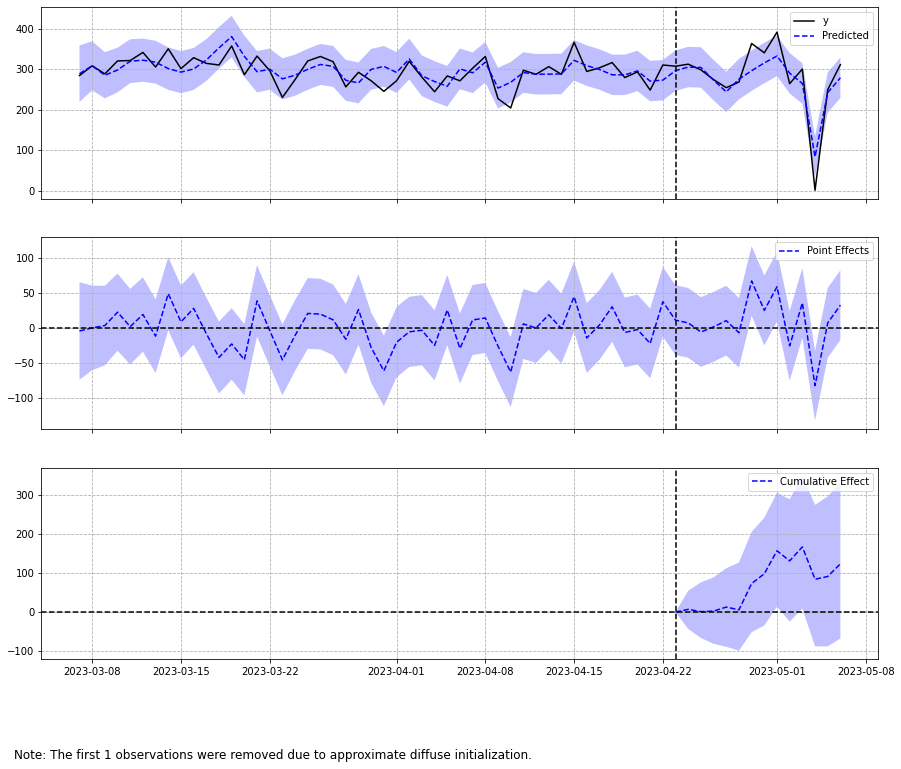

In [37]:
print('Orders plot, with a p_value of {}'.format(model_orders.p_value))
print(model_orders.summary('report'))
model_orders.plot()

PNA Ordres plot, with a p_value of 0.26073926073926074
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 85.69. In the absence of an
intervention, we would have expected an average response of 82.97.
The 95% interval of this counterfactual prediction is [74.23, 91.69].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 2.72 with a 95% interval of
[-6.0, 11.46]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1114.0.
Had the intervention not taken place, we would have expected
a sum of 1078.61. The 95% interval of this prediction is [964.99, 1192.01].


The above results are given in terms of absolute numbers. In relati

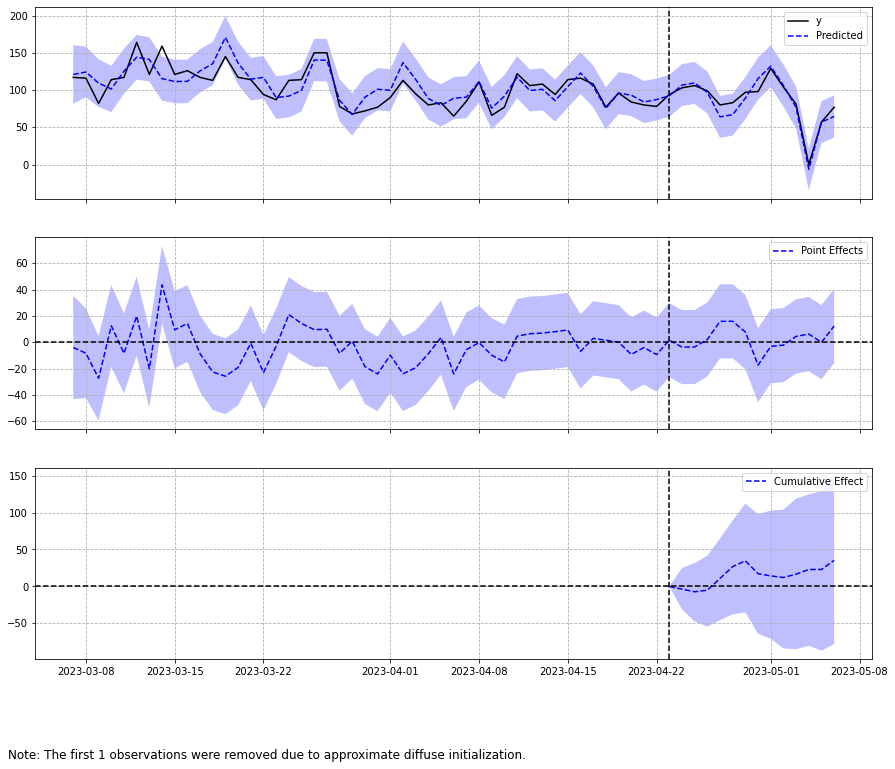

In [38]:
print('PNA Ordres plot, with a p_value of {}'.format(model_orders_pna.p_value))
print(model_orders_pna.summary('report'))
model_orders_pna.plot()

% Orders with PNA, with a p_value of 0.4645354645354645
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.28. In the absence of an
intervention, we would have expected an average response of 0.28.
The 95% interval of this counterfactual prediction is [0.26, 0.31].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.0 with a 95% interval of
[-0.02, 0.03]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 3.7.
Had the intervention not taken place, we would have expected
a sum of 3.69. The 95% interval of this prediction is [3.36, 3.99].


The above results are given in terms of absolute numbers. In relative
terms, the r

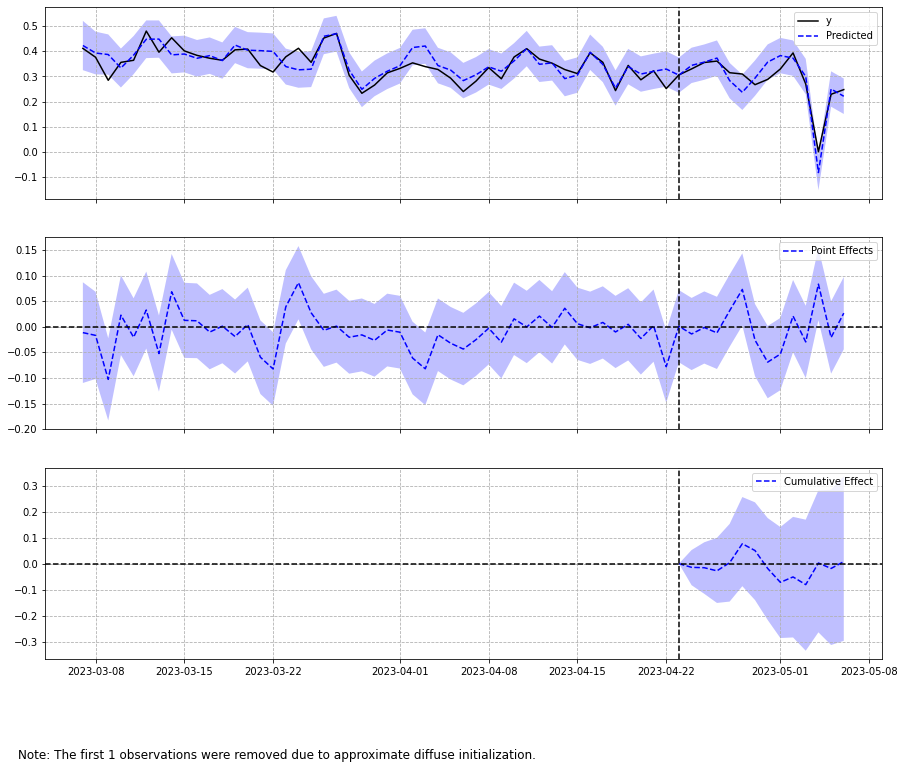

In [39]:
print('% Orders with PNA, with a p_value of {}'.format(model_perc_pna_orders.p_value))
print(model_perc_pna_orders.summary("report"))
model_perc_pna_orders.plot()